# Libraries

In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from textblob import TextBlob

# Loading the Files

Download the csv files into the `data/` directory.

In [20]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print(trainingSet.head(3))


print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)
        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   

   HelpfulnessDenominator        Time                             Summary  \
0                       2  1341014400                       GOOD FUN FILM   
1                       0  1168819200                        Movie Review   
2                       0  1386201600  When is it a good time to Consent?   

                                                Text  Score  
0  While most straight to DVD films are not worth...    5.0  
1  I have wanted this one for sometime, also.  I ...    5.0  
2  Actually this was a pretty darn good indie fil...    4.0  

EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


# Feature

In [ ]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    df['HighHelpfulness'] = (df['Helpfulness'] > 0.8).astype(int)  # Binary indicator for highly helpful reviews

    # 2. Length of the Review and Summary (in words and characters)
    df['ReviewLengthWords'] = df['Text'].apply(lambda x: len(str(x).split()))
    df['ReviewLengthChars'] = df['Text'].apply(lambda x: len(str(x)))
    df['SummaryLengthWords'] = df['Summary'].apply(lambda x: len(str(x).split()))
    df['SummaryLengthChars'] = df['Summary'].apply(lambda x: len(str(x)))

    # 3. Extract Time Features (Year, Month)
    df['ReviewYear'] = pd.to_datetime(df['Time'], unit='s').dt.year
    df['ReviewMonth'] = pd.to_datetime(df['Time'], unit='s').dt.month

    # 4. Sentiment Analysis (Polarity and Subjectivity for Text and Summary)
    df['TextSentimentPolarity'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['TextSentimentSubjectivity'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    df['SummarySentimentPolarity'] = df['Summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['SummarySentimentSubjectivity'] = df['Summary'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    # 5. Review Intensity and Uniqueness Features
    df['CapsWordsCount'] = df['Text'].apply(lambda x: sum(1 for word in str(x).split() if word.isupper()))
    df['UniqueWordCount'] = df['Text'].apply(lambda x: len(set(str(x).split())) / (len(str(x).split()) + 1))
    
    # Sentiment analysis using VADER for faster execution
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    import nltk
    nltk.download('vader_lexicon')
    sia = SentimentIntensityAnalyzer()
    df['polarity'] = df['Text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    test = add_features_to(testingSet)

    # Merge on 'Id' so that the submission set can have feature columns as well
    X_submission = pd.merge(test, train[['Id'] + list(train.columns.difference(test.columns))], on='Id', how='left')
    X_submission = X_submission.drop(columns=['Score_x'])  # Remove duplicate 'Score' column
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]

    # Save the processed DataFrames
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

print("Feature extraction and file saving completed.")


# Model


In [10]:
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import xgboost as xgb
import pandas as pd

# Sample the data
sampled_df = trainingSet.sample(frac=0.5, random_state=42)

# Ensure all entries in 'Text' and 'Summary' are strings
sampled_df['Text'] = sampled_df['Text'].astype(str)
sampled_df['Summary'] = sampled_df['Summary'].astype(str)

# Step 1: Apply feature engineering function
sampled_df = add_features_to(sampled_df)  # Uses the updated add_features_to function

# Step 2: Vectorize 'Text' and 'Summary' using TF-IDF
tfidf_text = TfidfVectorizer(max_features=5000)
train_text_tfidf = tfidf_text.fit_transform(sampled_df['Text'].fillna(''))

tfidf_summary = TfidfVectorizer(max_features=1000)
train_summary_tfidf = tfidf_summary.fit_transform(sampled_df['Summary'].fillna(''))

# Step 3: Combine the TF-IDF features with engineered numeric features
numeric_features = sampled_df[[
    'Helpfulness', 'HighHelpfulness', 'ReviewLengthWords', 'ReviewLengthChars', 
    'SummaryLengthWords', 'SummaryLengthChars', 'ReviewYear', 'ReviewMonth', 
    'TextSentimentPolarity', 'TextSentimentSubjectivity', 'SummarySentimentPolarity', 
    'SummarySentimentSubjectivity', 'CapsWordsCount', 'UniqueWordCount'
]].fillna(0)

# Combine TF-IDF and numeric features using hstack
X = hstack([train_text_tfidf, train_summary_tfidf, numeric_features.values])
y = sampled_df['Score'].fillna(0)  # Target variable

# Step 4: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=600,
    learning_rate=0.1, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8
)

xgb_model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = xgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'XGBoost Accuracy on Sampled Data: {accuracy}')


XGBoost Accuracy on Sampled Data: 0.5769819856969497


# File make

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

# Load X_submission.csv and apply feature engineering
X_submission = pd.read_csv("./data/X_submission.csv")

# Ensure 'Text' and 'Summary' columns in X_submission are strings for consistency
X_submission['Text'] = X_submission['Text'].astype(str)
X_submission['Summary'] = X_submission['Summary'].astype(str)

# Apply feature engineering using add_features_to function to ensure all required features are present
X_submission = add_features_to(X_submission)

# Vectorize the 'Text' column using the already fitted TF-IDF vectorizer
submission_text_tfidf = tfidf.transform(X_submission['Text'].fillna(''))

# Prepare numeric features (ensure the columns are present)
numeric_features_submission = X_submission[[
    'Helpfulness', 'review_length', 'summary_length', 
    'contains_positive_words', 'contains_negative_words', 
    'polarity'
]].fillna(0)

# Combine TF-IDF and numeric features using hstack
X_test = hstack([submission_text_tfidf, numeric_features_submission.values])

# Predict using the trained model
y_test_pred = xgb_model.predict(X_test)

# Round the predictions to the nearest integer between 1 and 5
y_test_pred_rounded = np.clip(np.round(y_test_pred), 1, 5)

# Create the submission DataFrame with 'Id' and 'Score'
X_submission['Score'] = y_test_pred_rounded
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

print("submission.csv created successfully.")

# Model Evaluation

Accuracy on testing set = 0.5769819856969497


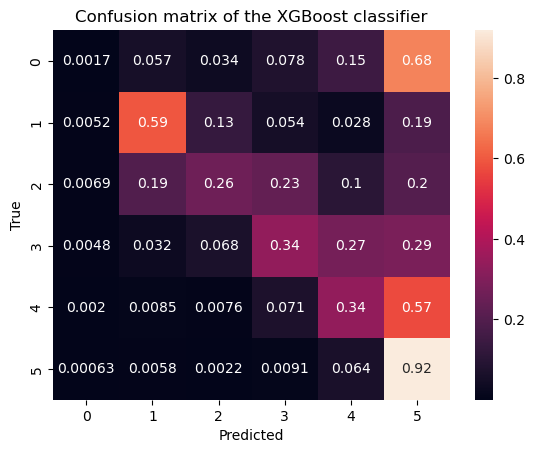

In [12]:
# Print accuracy score
print(f'Accuracy on testing set = {accuracy_score(y_val, y_pred)}')

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the XGBoost classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
